In [1]:
!nvidia-smi

Sat Oct 30 22:30:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Runtime
use_tpu = False #@param


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
np.random.seed(0)

In [4]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/solubility.npz",
    "solubility.npz",
)
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)

In [5]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=256,
                hidden_dim=128,
                embedding_dim=128,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )



In [6]:
def build_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalAveragePooling1D()(e)


    # RNN layer
    x = tf.keras.layers.LSTM(config.rnn_units)(e)
    x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn')
    return model

In [7]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [8]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
data = tf.data.Dataset.from_tensor_slices((features, labels))
# now split into val, test, train and batch
N = len(data)  
L = features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)

  # 50 epochs
  decay_steps = N  // config.batch_size * 50
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [10]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=25)],
    epochs=150)



Epoch 1/150
lr = 0.001
923/923 [==============================] - 24s 21ms/step - loss: 0.6954 - auc: 0.5195 - binary_accuracy: 0.5191 - val_loss: 0.6891 - val_auc: 0.5675 - val_binary_accuracy: 0.5312
Epoch 2/150
lr = 0.0009993684
923/923 [==============================] - 18s 19ms/step - loss: 0.6823 - auc: 0.5779 - binary_accuracy: 0.5617 - val_loss: 0.6741 - val_auc: 0.6123 - val_binary_accuracy: 0.5897
Epoch 3/150
lr = 0.0009974748
923/923 [==============================] - 18s 20ms/step - loss: 0.6880 - auc: 0.5491 - binary_accuracy: 0.5405 - val_loss: 0.6785 - val_auc: 0.6173 - val_binary_accuracy: 0.5566
Epoch 4/150
lr = 0.0009943242
923/923 [==============================] - 18s 20ms/step - loss: 0.6717 - auc: 0.6090 - binary_accuracy: 0.5830 - val_loss: 0.6698 - val_auc: 0.6192 - val_binary_accuracy: 0.5989
Epoch 5/150
lr = 0.0009899247
923/923 [==============================] - 18s 20ms/step - loss: 0.6679 - auc: 0.6177 - binary_accuracy: 0.5860 - val_loss: 0.6703 - val_auc:

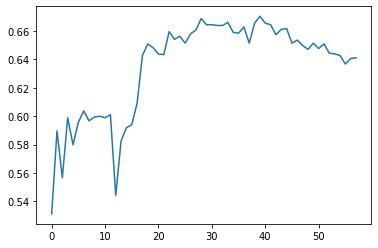

In [11]:
plt.plot(result.history['val_binary_accuracy'])
plt.show()

In [12]:
model.evaluate(test_data)

116/116 [==============================] - 1s 7ms/step - loss: 0.6217 - auc: 0.7176 - binary_accuracy: 0.6715


[0.621677041053772, 0.7176458239555359, 0.6715447306632996]